In [409]:
import numpy as np
import glob
import sys
import time
import datetime
import os
import pickle

import matplotlib.pyplot as plt

In [410]:
%matplotlib nbagg

Utilities
---------

In [2]:
def printError(*arg):
    print('Error:', *arg, file=sys.stderr)
    
def printDebug(*arg):
    print('Debug:', *arg, file=sys.stderr)
    
def printWarning(*arg):
    print('Warning:', *arg, file=sys.stderr)

Simulation Model
----------------

In [3]:
class WaterHeaterModel:
    def __init__(self, m_w=1, m_h=0.2, T_env=23, P=400, r=0.085,
                 c_pw=4200, c_ph=400, h_w=25, h_a=6, rho_w=1000, rho_h=8800):
        A_hw = np.pi * r ** 2
        V_w = m_w / rho_w
        H_w = V_w / A_hw
        A_wa = H_w * 2 * r * np.pi + A_hw

        V_h = m_h / rho_h
        H_h = V_h / A_hw
        A_ha = H_h * 2 * r * np.pi + A_hw

        alpha = -(h_w * A_hw + h_a * A_ha) / (c_ph * m_h)
        beta = h_w * A_hw / (c_ph * m_h)
        gamma = h_w * A_hw / (c_pw * m_w)
        delta = -(h_w * A_hw + h_a * A_wa) / (c_pw * m_w)

        self.A = np.array([[alpha, beta], [gamma, delta]])

        alpha = P / (c_ph * m_h)
        beta = h_a * A_ha / (c_ph * m_h) * T_env
        gamma = 0
        delta = h_a * A_wa / (c_pw * m_w) * T_env

        self.B = np.array([[alpha, beta], [gamma, delta]])
        
        self.state = np.array([[T_env] * 2], dtype=np.float64).transpose()

    def __call__(self, u, dt):
        u = np.array([[u, 1]]).transpose()
        
        self.state += (np.dot(self.A, self.state) + np.dot(self.B, u)) * dt
        
        return self.state

Simulator Interface
-------------------

In [764]:
class SimulatorInterface:
    def __init__(self, m=None, time_base=datetime.datetime.now, time_factor=1.0, switching_delay=5.0, accuracy=0.125):
        if m is None:
            m = np.random.rand() + 0.7
        
        self.model = WaterHeaterModel(m)
        self.heating = False
        self.time_base = time_base
        self.last_time = time_base()
        self.time_factor = time_factor
        self.switching_delay = switching_delay
        self.accuracy = accuracy
        self.last_temperature = np.random.rand() * 80 + 20
        self.relays = []
    
    def _update(self):
        current = self.time_base()
        dt = (current - self.last_time).total_seconds() * self.time_factor
        self.advance(dt, current)
        
    def advance(self, dt, current=None):
        if current is None:
            current = self.time_base()
        self.last_time = current
        
        self.relays = [(x[0] - dt, x[1]) for x in self.relays]
        
        while len(self.relays) > 0 and self.relays[0][0] <= 0:
            self.heating = self.relays[0][1]
            self.relays = self.relays[1:]
        
        self.model(float(self.heating), dt)
    
    def read_temperature(self):
        # note: ugly delay like we have in the actual sensor readings
        result = np.round(self.last_temperature / self.accuracy + np.random.randn(1)[0] / 3) * self.accuracy
        self._update()
        self.last_temperature = self.model.state[1][0]
        return result
    
    def write_relay(self, value):
        self._update()
        self.relays.append((self.switching_delay, value))
            
    def close(self):
        pass

Hardware interface
------------------

In [125]:
class ElectronicsInterface:
    def __init__(self, gpio_pin=18, sensor=None):
        self.pin = gpio_pin
        self.sensor = None
        self.GPIO = None
        
        if sensor is None:
            temperature_sensors = glob.glob('/sys/bus/w1/devices/28-*/w1_slave')
            
            if len(temperature_sensors) > 1:
                printError('multiple temperature sensors found, please specify - entering fake mode')
                return
            elif len(temperature_sensors) == 0:
                printError('temperature sensor cannot be found - entering fake mode')
                return
            else:
                printDebug('temperature sensor found: ' + temperature_sensors[0])
                sensor = temperature_sensors[0]
        
        self.sensor = sensor
        
        try:
            self.read_temperature()
        except:
            printError('temperature sensor cannot be read - entering fake mode.')
            self.sensor = None
            return
        
        try:
            import RPi.GPIO as GPIO
            
            GPIO.setmode(GPIO.BCM)
            GPIO.setup(gpio_pin, GPIO.OUT, initial=GPIO.LOW)
            
            self.GPIO = GPIO
            
            printDebug('GPIO up and running')
        except:
            self.GPIO = None
            printError('GPIO not working - entering fake mode')
            
    def read_temperature(self):
        if self.sensor is not None:
            with open(self.sensor, 'r') as f:
                lines = f.readlines()
        else:
            lines = ['69 01 ff ff 7f ff ff ff 7e : crc=7e YES\n', '69 01 ff ff 7f ff ff ff 7e t=22562\n']
            
        if lines[0].strip()[-3:] == 'YES':
            self.temperature = int(lines[1].strip().split('=')[1]) / 1000
        else:
            self.temperature = np.nan
            printWarning('no temperature read')
            
        return self.temperature
    
    def write_relay(self, value):
        if self.GPIO is not None:
            self.GPIO.output(self.pin, value)
            
    def close(self):
        if self.GPIO is not None:
            self.GPIO.cleanup(self.pin)

In [501]:
time_factor = 100.0

In [261]:
#interface = ElectronicsInterface()
interface = SimulatorInterface(time_factor=time_factor)

In [262]:
interface.write_relay(False)

Let's collect some data!
------------------------

In [263]:
temperatures = []

In [264]:
interface.read_temperature()

47.0954219328273

In [265]:
relay_on = True

interface.write_relay(True)

# run for an hour max
for i in range(3600):
    temperature = interface.read_temperature()
    temperatures.append(temperature)
    print(temperature)
    
    if relay_on and temperature >= 50:
        interface.write_relay(False)
        relay_on = False
        
    if os.path.exists('/tmp/stop'):
        break
    
    time.sleep(1 / time_factor)
    
if relay_on:
    interface.write_relay(False)
    relay_on = False

23.0
23.0
23.0
23.0
23.0
23.0
23.0008526204
23.0025561882
23.0050821461
23.0084457088
23.0127477014
23.0181958213
23.0246405586
23.0328577396
23.0407609934
23.0506727505
23.0611093466
23.0713648097
23.0822763549
23.0950023283
23.1075400754
23.1215868328
23.1358154908
23.1508510403
23.1661146789
23.1819590964
23.1984082443
23.2156877795
23.2335784493
23.2519556718
23.2709292558
23.2905066111
23.3115483268
23.3346023335
23.3611847071
23.3878562505
23.4139228843
23.4396197328
23.4707778949
23.4973123512
23.5237391527
23.5517886945
23.5801643333
23.613506804
23.648064891
23.6796186739
23.7099908932
23.7402446117
23.7798565249
23.8142119522
23.8502589182
23.884201407
23.9200315955
23.9592288056
23.9948781476
24.031025738
24.0699107632
24.1070035725
24.1464140392
24.1827966776
24.2207522179
24.2606096642
24.3019244424
24.3415315946
24.3796822289
24.4183839972
24.458531437
24.5004661805
24.5419777973
24.5859103956
24.6319631092
24.6759747937
24.7233954973
24.7672758594
24.813249146
24.8586793

In [266]:
interface.read_temperature()

48.050638028674285

In [267]:
interface.close()

### Investiage

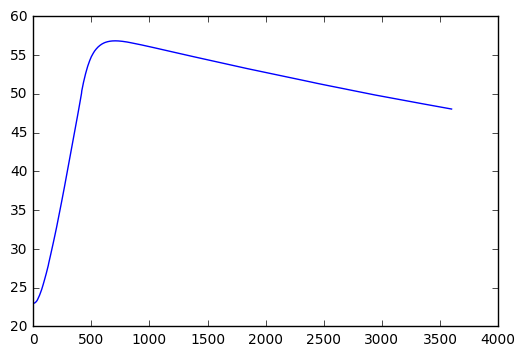

In [268]:
fig = plt.figure()
plt.plot(temperatures)

In [269]:
max(temperatures)

56.851921797418413

In [270]:
np.where(np.array(temperatures) > 50)[0][0]

415

In [271]:
c = 4190
m = 1
dT = max(temperatures) - min(temperatures)
dQ = c * m * dT
P = 400
t = np.where(np.array(temperatures) > 50)[0][0]
E = P * t
nu = dQ / E
print('Wirkungsgrad:', nu)

Wirkungsgrad: 0.854455134525


In [272]:
dQ

141839.55233118316

In [273]:
dT

33.851921797418413

In [274]:
t

415

Second Data Collection: Simple hysteresis control
-------------------------------------------------

In [669]:
temperatures = []

In [670]:
target_temperature = 50

In [671]:
interface = SimulatorInterface(time_factor=time_factor)

In [672]:
interface.read_temperature()

20.70731172150202

In [673]:
dT = target_temperature - interface.read_temperature()

In [674]:
dQ = c * m * dT
boost_time = dQ / (P * nu)

In [675]:
boost_time

331.00041017034675

In [676]:
is_boosting = True
is_controlling = False

relay_on = True

interface.write_relay(True)

start_time = datetime.datetime.now()
last_temp = 0

# run for an two hours max
for i in range(3600 * 3):
    now = datetime.datetime.now()
    temperature = interface.read_temperature()
    temperatures.append((now, temperature, relay_on))
    print(temperature)
    
    if is_boosting:
        if i > boost_time:
            if relay_on:
                interface.write_relay(False)
                relay_on = False
                print('Reached boost time, turning off:', now)
            elif last_temp > temperature:
                print('Temperature falling again, starting control:', now)
                is_boosting = False
                is_controlling = True
                
        last_temp = temperature
    elif is_controlling:
        if i >= 3600 * 3:
            is_controlling = False
            print('Stopping controlling:', now)
            
            if relay_on:
                interface.write_relay(False)
                relay_on = False
            
        elif relay_on and temperature >= target_temperature:
            interface.write_relay(False)
            relay_on = False
        elif not relay_on and temperature < target_temperature:
            interface.write_relay(True)
            relay_on = True
            
        
    if os.path.exists('/tmp/stop'):
        break
        
    sleep_time = i + 1 - (datetime.datetime.now() - start_time).total_seconds() * time_factor
    
    if sleep_time > 0:
        time.sleep(sleep_time / time_factor)
    
if relay_on:
    interface.write_relay(False)
    relay_on = False

23.0
23.0
23.0
23.0
23.0
23.0
23.0
23.0005551263
23.0016653673
23.0033167798
23.0055123092
23.0082457302
23.0115115398
23.0153049396
23.0196116802
23.0244598768
23.0297931736
23.0356464938
23.0420252717
23.0488765669
23.056225331
23.064087462
23.0724212696
23.0812141584
23.0905007928
23.1002416589
23.1104860904
23.1211857053
23.1323561081
23.1439653403
23.1559974463
23.1685039334
23.181481259
23.1948947041
23.2087632676
23.2230247695
23.2376847746
23.2527882763
23.2683254634
23.284261765
23.3006526106
23.3174689559
23.3346360174
23.3521865687
23.3701391711
23.3885494015
23.4072958326
23.4264499537
23.4460095393
23.4659285518
23.4862083823
23.5069356693
23.5279532405
23.5493390528
23.5711530402
23.5932645923
23.6157437819
23.638576495
23.6617711285
23.6852991389
23.7091997506
23.7334395856
23.7580817672
23.7829141994
23.8081121302
23.8336867347
23.8595903072
23.8859274403
23.9123835351
23.9391335635
23.9662418209
23.9937537723
24.0215669725
24.049627778
24.0780393726
24.1067116081
24.13

In [677]:
interface.close()

In [678]:
temperatures[-1]

(datetime.datetime(2017, 1, 8, 21, 40, 17, 481928), 50.506361625162349, False)

In [679]:
start_time

datetime.datetime(2017, 1, 8, 21, 38, 29, 491849)

<IPython.core.display.Javascript object>


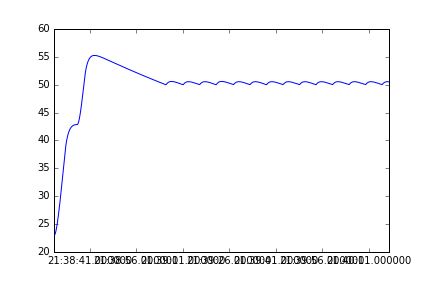

In [680]:
plt.figure()
plt.plot([t[0] for t in temperatures], [t[1] for t in temperatures])

Let's try our own control mechanism
-----------------------------------

In [784]:
temperatures = []

In [785]:
target_temperature = 50

In [786]:
interface = SimulatorInterface(time_factor=time_factor)

In [787]:
interface.read_temperature()

89.5

In [788]:
v_boost = c * m / (P * nu)
v_boost

12.259274450753585

In [789]:
dT = target_temperature - interface.read_temperature()

In [790]:
boost_time = v_boost * dT

In [791]:
boost_time

331.00041017034681

In [792]:
from enum import Enum, auto

In [793]:
class States(Enum):
    BOOST = auto()
    OVERSHOOT = auto()
    CONTROL = auto()

In [794]:
CONTROL_EPSILON = 0.5
F_SWITCH = 1 / 15
T_CONT = 2 / F_SWITCH
F_READ = 1
T_READ = 1 / F_READ
N_CONTROL = int(T_CONT / T_READ)
NE_CONTROL = 4

NM_CONTROL = 3
NC_CONTROL = 4

TARGET_ACCURACY = 0.2
MAXIMUM_CONTROL_ERROR = 1.0
BOOST_COOL_SAMPLES = 10

In [795]:
state = States.OVERSHOOT

relay_on = False
interface.write_relay(False)

start_time = datetime.datetime.now()
handling_temps = []

control_a = 0.1
control_mu = 0.1
control_n = 0
#control_last_errors = []
control_means = []
control_changes = []

control_turnoff = 0

start_boost = False
start_cooling = True
start_control = False

boost_time = 0
boost_cool = 0
boost_heat = 0
boost_samples = 0
boost_start = 0

# run for three hours max
for i in range(3600 * 3):
    last_time = now
    now = datetime.datetime.now()
    temperature = interface.read_temperature()
    temperatures.append((now, temperature, relay_on, state.value, control_a, control_mu, v_boost))
    handling_temps.append(temperature)
    print(temperature)
    
    dt = (now - last_time).total_seconds() * time_factor
    
    if control_turnoff > 0:
        control_turnoff -= dt
    if boost_time > 0:
        boost_time -= dt
    
    relay_target = relay_on
    
    if state == States.CONTROL:
        control_n += 1
        
        if start_control:
            control_n = 0
            #control_last_errors = []
            
            control_means = []
            control_changes = []

            start_control = False
        
        if control_n == N_CONTROL:
            control_n = 0
            
            #e = np.mean(handling_temps[-N_CONTROL:]) - target_temperature
            #control_last_errors.append(np.sign(e) if np.abs(e) - TARGET_ACCURACY > 0 else 0)
            
            #if len(control_last_errors) >= NE_CONTROL:
            #    control_last_errors = control_last_errors[-NE_CONTROL:]
            #    
            #    #if np.sum(np.abs(control_last_errors)) != 0:
            #    avg_e = np.abs(np.mean(control_last_errors))

            #    control_mu = control_mu * (.5 if avg_e < 1 / NE_CONTROL else (2 if avg_e == NE_CONTROL else 1))

            #control_a -= control_mu * control_last_errors[-1]
            #control_a = np.clip(control_a, 0, 1)

            control_means.append(np.mean(handling_temps[-N_CONTROL:]))
            
            if len(control_means) >= NM_CONTROL:
                control_means = control_means[-NM_CONTROL:]
                direction = np.sign(np.array(control_means[1:]) - control_means[:-1])
                
                a_change = 0
                
                if (direction == -1).all() and control_means[-1] < target_temperature:
                    a_change = 1
                elif (direction == 1).all() and control_means[-1] > target_temperature:
                    a_change = -1
                
                if a_change != 0:
                    control_a += control_mu * a_change
                    
                    control_changes.append(a_change)
                    
                    control_means = []
                    
            if len(control_changes) >= NC_CONTROL:
                control_changes = control_changes[-NC_CONTROL:]
                
                if sum(control_changes) == 0:
                    control_mu /= 2
                    control_changes = []
                elif np.abs(sum(control_changes)) == NC_CONTROL:
                    control_mu *= 2
                    control_changes = []
            
            if handling_temps[-1] > target_temperature + MAXIMUM_CONTROL_ERROR:
                state = States.OVERSHOOT
                start_cooling = True
                #control_a -= control_mu
                #control_changes.append(-1)
                
            elif handling_temps[-1] < target_temperature - MAXIMUM_CONTROL_ERROR:
                state = States.BOOST
                start_boost = True
            
        if control_n == 0 and state == States.CONTROL:
            relay_target = True
            control_turnoff = control_a * T_CONT
        
    elif state == States.BOOST:
        if start_boost:
            boost_start = handling_temps[-1]
            dT = target_temperature - boost_start
            boost_time = v_boost * dT
            boost_heat = boost_time
            
            relay_target = True
            start_boost = False
            boost_samples = 0
        else:
            boost_samples += 1
        
        if boost_time <= 0:
            if relay_on:
                relay_target = False
                boost_heat -= boost_time
                boost_cool = 0
            else:
                boost_cool += dt
                
                if len(handling_temps) > BOOST_COOL_SAMPLES:
                    if np.mean(np.array(handling_temps[-BOOST_COOL_SAMPLES - 1:-1]) - np.array(handling_temps[-BOOST_COOL_SAMPLES:])) > 0:
                        v_boost = boost_heat / (np.max(handling_temps[-boost_samples:]) - boost_start)
                        print('New v_boost:', v_boost)
                        
                        if handling_temps[-1] > target_temperature:
                            state = States.OVERSHOOT
                            start_cooling = True
                            #v_boost /= 2
                            # TODO: v_boost is BAD now!
                        elif handling_temps[-1] > target_temperature - CONTROL_EPSILON:
                            state = States.CONTROL
                            start_control = True
                        else:
                            start_boost = True
        
        # overshooting, stop heating early!
        elif relay_on and handling_temps[-1] >= target_temperature:
            relay_target = False
            boost_heat -= boost_time
            boost_time = 0
            boost_cool = 0
        
    elif state == States.OVERSHOOT:
        relay_target = False
        
        if handling_temps[-1] < target_temperature - CONTROL_EPSILON:
            state = States.BOOST
            start_boost = True
        elif handling_temps[-1] < target_temperature:
            state = States.CONTROL
            start_control = True

    # actually switch the relay!
    if relay_on != relay_target:
        relay_on = relay_target
        interface.write_relay(relay_on)
        
    if os.path.exists('/tmp/stop'):
        break
        
    sleep_time = i + 1 - (datetime.datetime.now() - start_time).total_seconds() * time_factor
    
    if state == States.CONTROL and relay_on and sleep_time > control_turnoff:
        if control_turnoff > 0:
            time.sleep(control_turnoff / time_factor)
        control_turnoff = 0
        relay_on = False
        interface.write_relay(relay_on)
        
        sleep_time -= control_turnoff
    
    if sleep_time > 0:
        time.sleep(sleep_time / time_factor)
    
if relay_on:
    interface.write_relay(False)
    relay_on = False

23.0
23.0
23.0
23.0
23.0
23.0
23.0
23.0
23.125
23.0
23.0
23.0
23.0
23.0
23.0
23.125
23.0
23.0
23.125
23.125
23.0
23.125
23.0
23.125
23.125
23.125
23.125
23.125
23.125
23.125
23.25
23.125
23.25
23.125
23.25
23.25
23.25
23.25
23.375
23.375
23.375
23.375
23.375
23.375
23.25
23.375
23.5
23.5
23.625
23.5
23.625
23.625
23.5
23.75
23.75
23.75
23.75
23.75
23.75
23.75
23.875
23.875
23.875
23.875
24.0
24.0
24.0
24.125
24.0
24.125
24.125
24.25
24.25
24.25
24.375
24.375
24.375
24.5
24.5
24.5
24.5
24.5
24.625
24.625
24.625
24.75
24.75
24.875
24.75
24.875
24.875
25.0
25.0
25.0
25.125
25.0
25.25
25.25
25.25
25.25
25.375
25.375
25.375
25.5
25.5
25.5
25.625
25.625
25.75
25.75
25.875
25.875
25.875
26.0
25.875
26.125
26.125
26.25
26.375
26.25
26.375
26.375
26.375
26.5
26.5
26.5
26.625
26.625
26.75
26.75
26.75
26.875
26.875
27.0
27.0
27.125
27.125
27.25
27.125
27.375
27.375
27.375
27.375
27.5
27.625
27.625
27.625
27.75
27.75
27.875
27.875
28.0
28.0
28.125
28.125
28.25
28.125
28.25
28.375
28.5
28.5
28.625


In [796]:
interface.close()

In [797]:
temperatures[-1]

(datetime.datetime(2017, 1, 8, 22, 2, 58, 522643),
 49.875,
 False,
 3,
 0.04375000000000002,
 0.00625,
 12.953180952380947)

In [798]:
start_time

datetime.datetime(2017, 1, 8, 22, 1, 10, 532568)

In [799]:
N_CONTROL

30

<IPython.core.display.Javascript object>


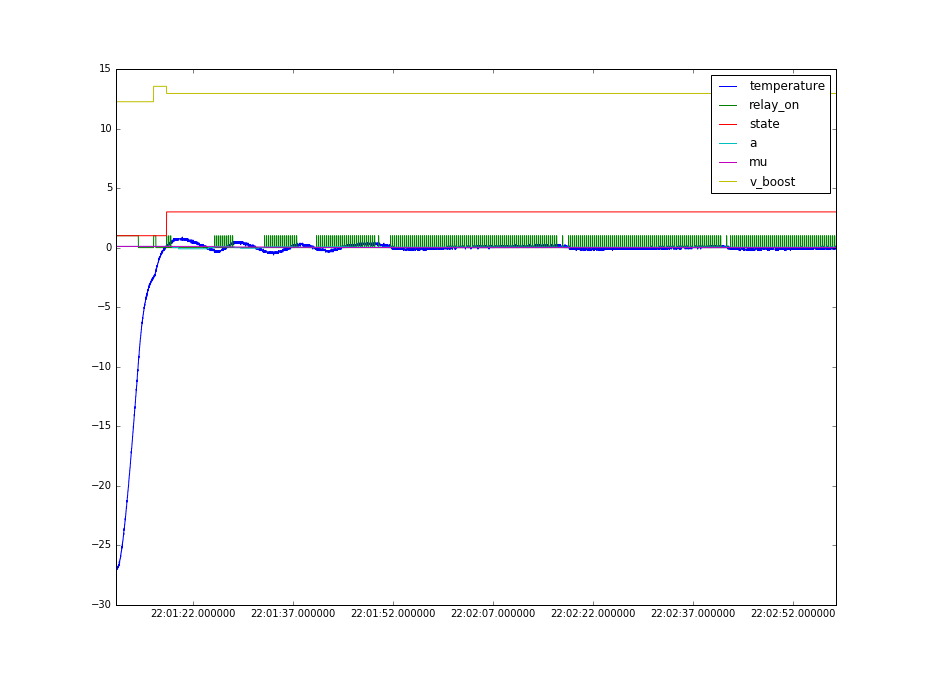

In [800]:
fig = plt.figure()
plt.plot([t[0] for t in temperatures], [t[1] - 50 for t in temperatures])
plt.plot([t[0] for t in temperatures], [t[2] for t in temperatures])
plt.plot([t[0] for t in temperatures], [t[3] for t in temperatures])
plt.plot([t[0] for t in temperatures], [t[4] for t in temperatures])
plt.plot([t[0] for t in temperatures], [t[5] for t in temperatures])
plt.plot([t[0] for t in temperatures], [t[6] for t in temperatures])
plt.legend(['temperature', 'relay_on', 'state', 'a', 'mu', 'v_boost'])